By Danilo Aballay, Federico Fuentes, Vicente Iligaray, Ángel J. Omella, David Pardo, Manuel A. Sánchez, Ignacio Tapia, Carlos Uriarte

This notebook is used for the two material problem:
$$u(x) = \frac{sin(2\pi x)}{\sigma(x)}$$

$$ \sigma = \begin{cases} 1 & 0\leq x\leq 0.5\\10& 0.5<x\leq 1\end{cases}$$


In [1]:
# Import libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.integrate import quad

os.environ["KERAS_BACKEND"] = "jax"

import keras

from fem_system import solve, solve_and_loss
from r_adaptivity_NN import make_model, make_loss_model, lr_schedule, tricky_loss
from Problem import Problem

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)
jax.config.update('jax_default_device', jax.devices('cpu')[0])

2025-06-10 16:53:04.532261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-10 16:53:04.542910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-10 16:53:04.547350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def Exact_Ritz():
    problem_test = Problem()
    rho = problem_test.sigma[-1]
    return - (np.pi**2) / 2 - (np.pi**2) / (2 * rho)   


In [7]:
# Create the model
# Number of elements
N = 16
# Number of neurons 
nn = N-1
# Number of training iterations
iterations = 1000

# Initialize the neural network model for the approximate solution
model = make_model(nn)

# Save initial nodes
init_nodes = model(jnp.array([1]))

# Create loss model
loss_model = make_loss_model(model)

# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)

# Learning rate schedule

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

In [8]:
# Train the model
start_time = time.time()
history    = loss_model.fit(jnp.array([1.]), jnp.array([1.]), epochs=iterations, callbacks = [lr_scheduler], verbose=0)
end_time   = time.time() 
print('Training time: ', end_time - start_time)

Training time:  2.783618211746216


e_h: 0.1130715226453658
e_theta: 0.09064403636040064


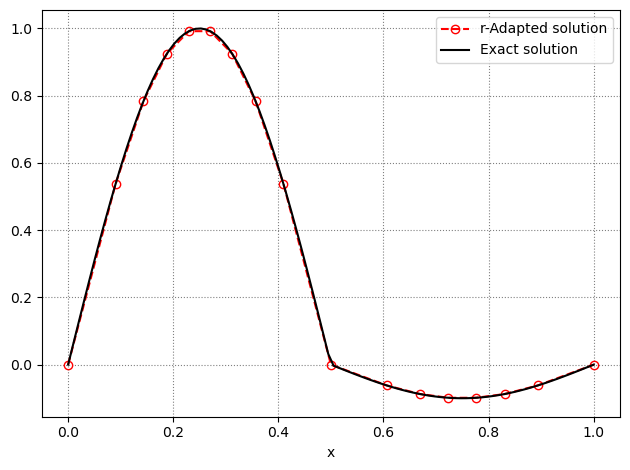

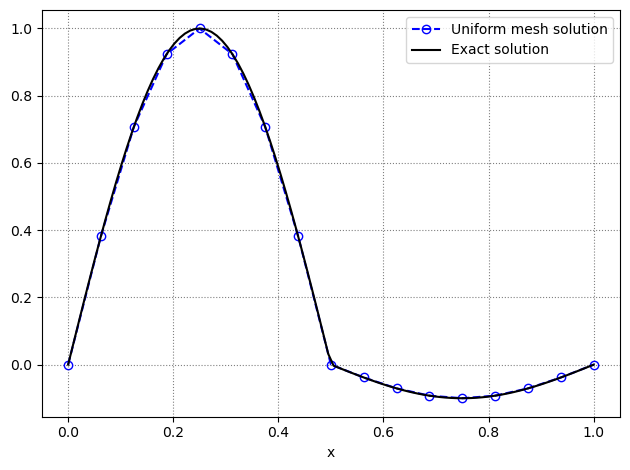

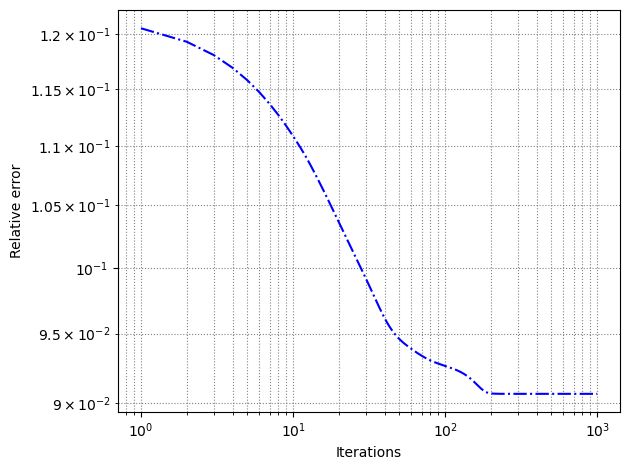

In [10]:
# Plot results
uniform_nodes = jnp.linspace(0, 1, nn+2)

node_coords, u    = solve(model(jnp.array([1])))
uniform_coords, o = solve(uniform_nodes)
problem_test      = Problem()
x     = np.linspace(0, 1, 100)

def sigma(x):
    return np.where(x < 0.5, problem_test.sigma[0], problem_test.sigma[-1])

y = jnp.sin(2 * np.pi * x) / sigma(x)

J_u_theta = np.array(history.history['loss'])
J_u       = Exact_Ritz()
J_u_h     = solve_and_loss(uniform_nodes)

rel_error_theta = np.sqrt((J_u - J_u_theta)/J_u)
rel_error_h = np.sqrt((J_u - J_u_h)/J_u)

print('e_h:', rel_error_h)
print('e_theta:', rel_error_theta[-1])

# Plot the approximate solution obtained from the trained model
plt.figure(1)
plt.plot(node_coords, u,'o--', color='r', fillstyle='none')
plt.plot(x, y, color='k')
plt.xlabel('x')
plt.legend(['r-Adapted solution', 'Exact solution'])
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot the approximate solution obtained from the uniform mesh
plt.figure(2)
plt.plot(uniform_coords, o, 'o--', color='b', fillstyle='none')
plt.plot(x, y, color='k')
plt.xlabel('x')
plt.legend(['Uniform mesh solution', 'Exact solution'])
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

# Plot the relative error
plt.figure(3)
plt.loglog(np.arange(1,iterations+1), rel_error_theta,'-.', color='b')
plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

plt.show()